# Grover's Algorithm

### Background
Usage Estimate: 4 seconds on ibm_nairobi. (NOTE: This is an estimate only. Your runtime may vary)

Amplitde amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. Grover's algorithm was the first to demonstrate this speedup on unstrcutred search problems. Fromulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are intersted in finding, and an amplification circuit that increases the amplitude of marked states, consequenly suppressing the remaining states.

Here, we demonstrate how to construct Grover oracles and use the GroverOperator from the Qiskit circuit library to easily set up a Grover's search instance. The runtim Sample primitve allows seamless execution of Grvoer circuits.

### Requirements
Before starting this tutorial, ensure that you have the following installed:
- Qiskit SDK 1.0 or later, with visualization support (pip install 'qiskit[visualization]')
- Qiskit Runtime (pip install qiskit-ibm-runtime) 0.22 or later

In case the $a=1$, the probability varies with N as

In [3]:
import numpy as np
import math
for n in range(1, 20):
    N = 2**n
    theta = np.arcsin(np.sqrt(1 / N))
    t = math.floor(np.pi / (4 * theta))
    p = np.sin((2 * t + 1) * theta) ** 2
    print("%d\t %12.10f" % (N, p))

2	 0.5000000000
4	 1.0000000000
8	 0.9453125000
16	 0.9613189697
32	 0.9991823155
64	 0.9965856808
128	 0.9956198657
256	 0.9999470421
512	 0.9994480262
1024	 0.9994612447
2048	 0.9999968478
4096	 0.9999453461
8192	 0.9999157752
16384	 0.9999997811
32768	 0.9999868295
65536	 0.9999882596
131072	 0.9999992587
262144	 0.9999978382
524288	 0.9999997279


In case of Multiple Solutions

In [4]:
# We'll start the loop with n=2 to stay within the domain of arcsin.
# (Note that we can't have 4 solutions when n=1.)

for n in range(2, 20):
    N = 2**n
    old_theta = np.arcsin(np.sqrt(1 / N))
    new_theta = np.arcsin(np.sqrt(4 / N))
    t = math.floor(np.pi / (4 * old_theta))
    p = np.sin((2 * t + 1) * new_theta) ** 2
    print("%d\t %12.10f" % (N, p))

4	 1.0000000000
8	 0.5000000000
16	 0.2500000000
32	 0.0122070313
64	 0.0203807689
128	 0.0144530758
256	 0.0000705058
512	 0.0019310741
1024	 0.0023009083
2048	 0.0000077506
4096	 0.0002301502
8192	 0.0003439882
16384	 0.0000007053
32768	 0.0000533810
65536	 0.0000472907
131072	 0.0000030066
262144	 0.0000086824
524288	 0.0000010820


### Setup
Here we import the small number of tools we need for this tutorial

In [1]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

## Step 1: Map classical inputs to a quantum problem

Grover's algorithm requires an oracle that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1, A controlled-Z gate, or its multi-controlled generation over N qubits, marks the $2^N-1$ state ('1' * N bit-string). Marking basis states with one or more '0' in the binary representation requires applying X-gates on the corresponding qubtis before and after the controlled-Z gate; equivalent to having an open-control on that qubit. In the following code, we define an oracle tht does just that, marking one or more input basis states defined through their bit-string representation. The MCMT gate is used to implement the multi-controlled Z gate.

In [3]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

### Specific Grover's Instance
Now that we have the oracle function, we can define a specific instance of Grover search. In this example we will mark two computational state out of the eight available in a three-qubit computational space:

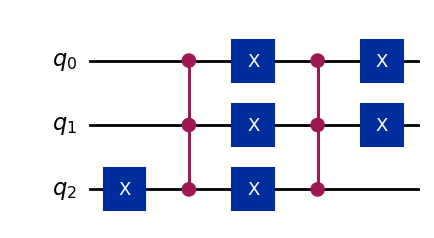

In [5]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

### GroverOperator
The built-in Qiskit GroverOperator takes an oracle circuit and returns a circuit that is composed of the oracle circuit and a circuit that amplifies the states marked by the oracle. Here, we decompose the circuit to see the gates within the operator:

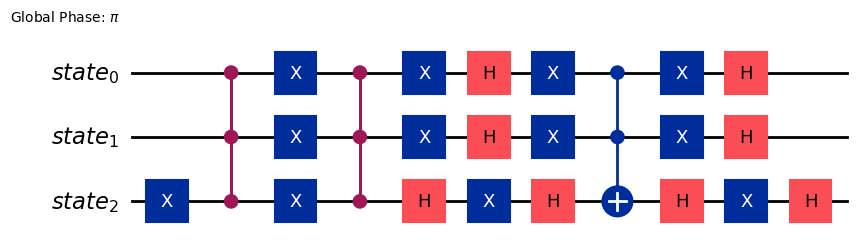

In [6]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Repeated application of this grover_op circtui amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit. There is an optimal number of such application that is determined by the ratio of marked states to the total number of possible computational states:

In [7]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

### Full grover circuit
A complete Grover experiment starts with a Hadamard gate on each qubit; creating an even superposition of all computational basis states, followed the Grover operator (grover_op) repeated the optimzal number of times. Here we make use of the QuantumCircuit.power(INT) method to repeatedly apply the Grover operator.

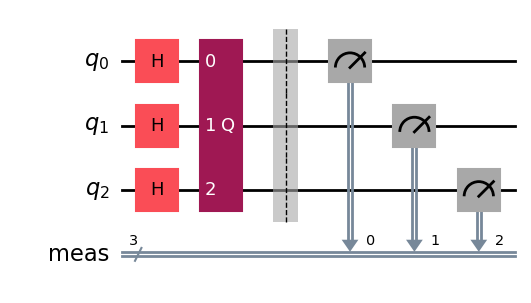

In [8]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## Step 2: Optimize problem for quantum execution

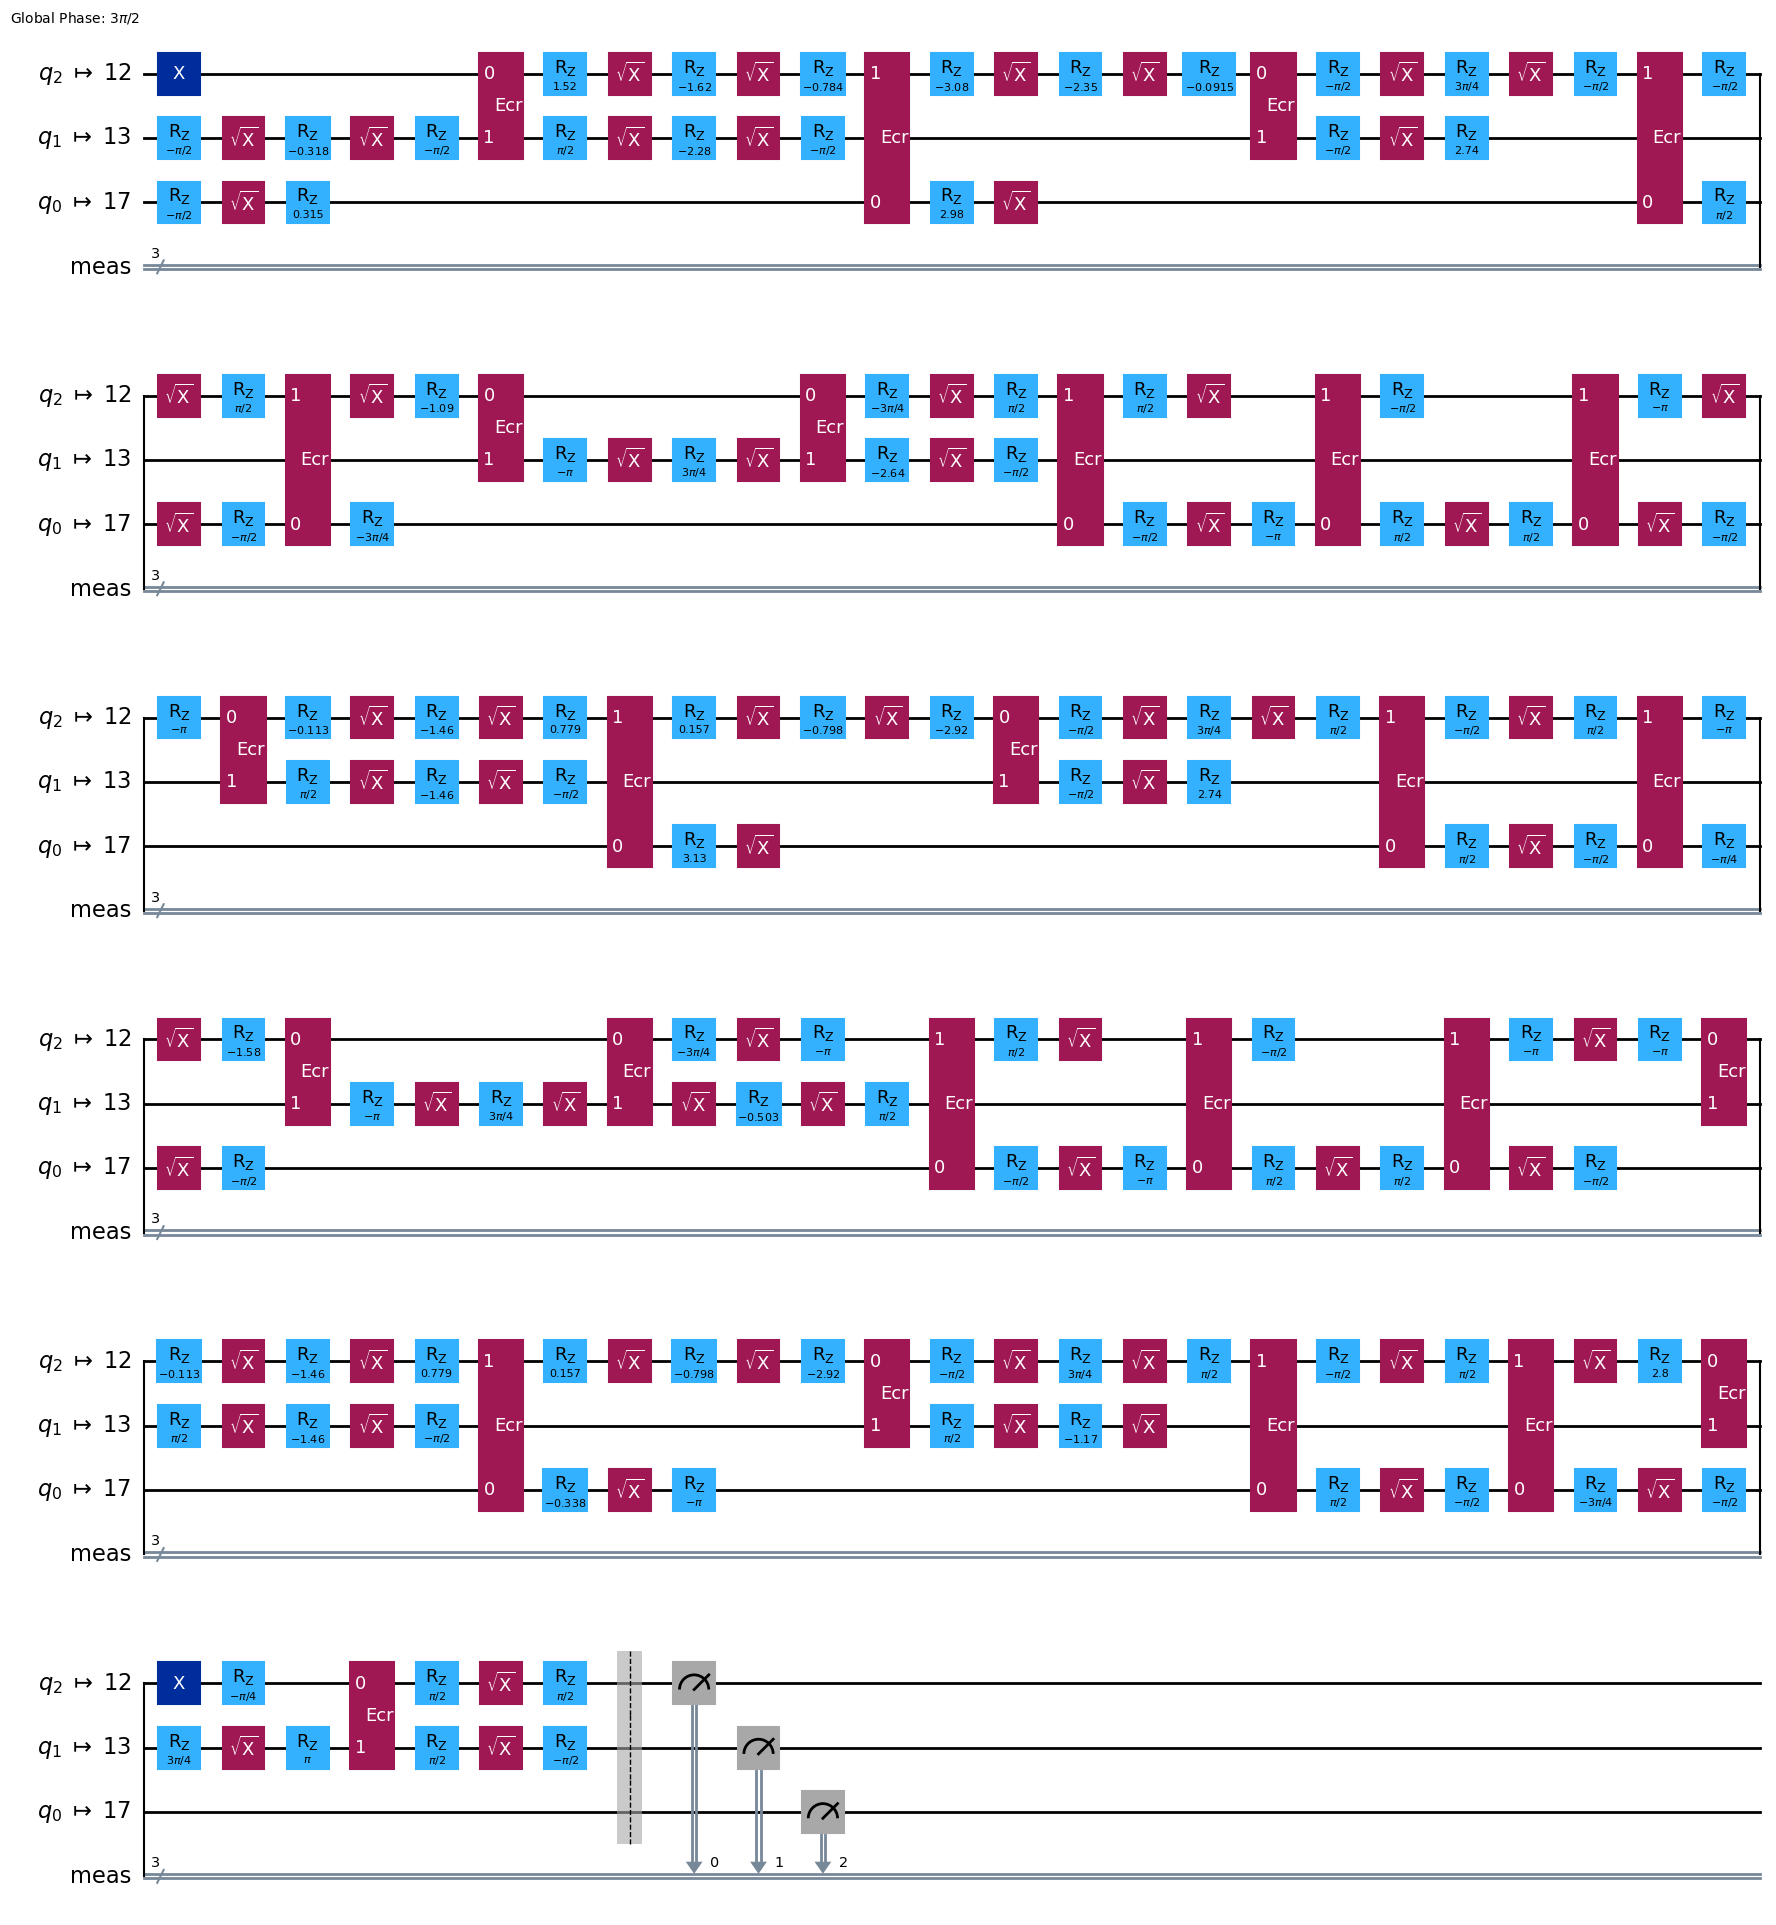

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

### Step 3: Execute using Qiskit Primitives
Amplitude amplification is a sampling problem tha is suitable for execution with the Sampler runtime primitive.

Note that the run() method of Qiskit Runtim SampleV2 takes an iterable of primitive unified blocs (PUBs). For sampler, eac PUB is an iterable in the format (circuit, parameter_values). However, at a minimum, it takes a list of quantum circuit(s).

In [10]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

## Step 4: Post-Process, return result in classical format

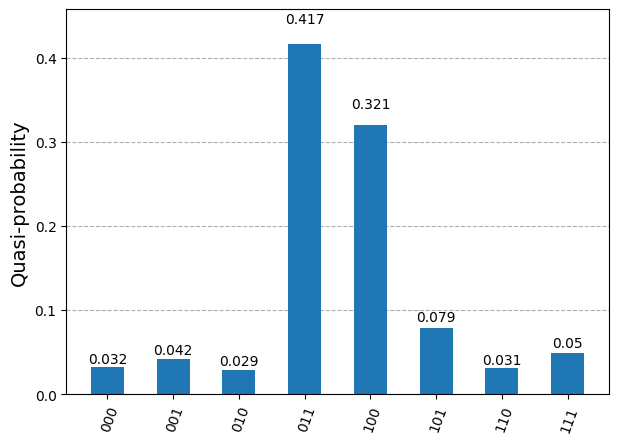

In [11]:
plot_distribution(dist)

In [12]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

In [14]:
import qiskit

qiskit.version.get_version_info()

'1.1.0'